In [53]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical
from scipy.signal import butter, filtfilt
from scipy.stats import ttest_ind, wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

# Function definitions for data preprocessing, quaternion conversion, and SVD feature extraction

def load_data(segment_size, overlap, base_paths):
    data = []
    labels = []
    for label, path in base_paths.items():
        for fname in tqdm(os.listdir(path)):
            file_path = os.path.join(path, fname)
            img = np.loadtxt(file_path)
            segmented_data = segment_signal(img, segment_size, overlap)
            for segment in segmented_data:
                filtered_data = bandpass_filter(segment)
                quaternion_data = convert_to_quaternion(filtered_data, segment)
                quaternion_data = np.array(quaternion_data)

                U, S, Vt = np.linalg.svd(quaternion_data, full_matrices=False)
                features = extract_features(U, S, Vt)

                data.append(features)
                labels.append(label)

    return np.array(data), np.array(labels)

def bandpass_filter(data, lowcut=0.5, highcut=30.0, fs=256, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def convert_to_quaternion(filtered_data, raw_data):
    quaternion_data = np.column_stack((filtered_data, filtered_data, raw_data, raw_data))
    return quaternion_data

def extract_features(U, S, Vt):
    energy = np.sum(S**2)
    entropy = -np.sum(S * np.log(S + 1e-10))
    spectral_norm = np.max(S)
    condition_number = np.max(S) / (np.min(S) + 1e-10)
    frobenius_norm = np.sqrt(np.sum(S**2))
    cumulative_sum = np.cumsum(S) / np.sum(S)
    normalized_singular_values = S / np.sum(S)

    features = {
        'svd_u_mean': np.mean(U),
        'svd_u_std': np.std(U),
        'svd_s_mean': np.mean(S),
        'svd_s_std': np.std(S),
        'svd_vt_mean': np.mean(Vt),
        'svd_vt_std': np.std(Vt),
        'svd_energy': energy,
        'svd_entropy': entropy,
        'svd_spectral_norm': spectral_norm,
        'svd_condition_number': condition_number,
        'svd_frobenius_norm': frobenius_norm,
        'svd_cumulative_sum_1': cumulative_sum[0],
        'svd_cumulative_sum_2': cumulative_sum[1],
        'svd_cumulative_sum_3': cumulative_sum[2],
        'svd_normalized_sv_1': normalized_singular_values[0],
        'svd_normalized_sv_2': normalized_singular_values[1],
        'svd_normalized_sv_3': normalized_singular_values[2],
    }
    return list(features.values())

def segment_signal(signal, segment_size, overlap):
    segments = []
    step = segment_size - overlap
    for start in range(0, len(signal) - segment_size + 1, step):
        segments.append(signal[start:start + segment_size])
    return segments

# Define file paths and segment parameters
segment_size = 128
overlap = 64
base_paths = {
    # 0: "/content/drive/MyDrive/Database/Bonn Univ Dataset/f/F/",
    # 1: "/content/drive/MyDrive/Database/Bonn Univ Dataset/n/N/",
    # 2: "/content/drive/MyDrive/Database/Bonn Univ Dataset/o/O/",
    3: "/content/drive/MyDrive/Database/Bonn Univ Dataset/s/S/",
    4: "/content/drive/MyDrive/Database/Bonn Univ Dataset/z/Z/"
}

# Load and preprocess data
data, labels = load_data(segment_size, overlap, base_paths)
scaler = StandardScaler()
data = scaler.fit_transform(data)



100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


In [54]:
# Convert labels to categorical format
labels = to_categorical(labels, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Reshape data for LSTM and CNN input
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define and train Bi-LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))

# Define and train CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
cnn_model.add(MaxPooling1D(2))
cnn_model.add(Conv1D(128, 3, activation='relu'))
cnn_model.add(MaxPooling1D(2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(5, activation='softmax'))
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))

# Train Decision Tree model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train.argmax(axis=1))

# Predict and evaluate Decision Tree
y_pred_dt = dt_clf.predict(X_test)
print("Decision Tree Classification Report")
print(classification_report(y_test.argmax(axis=1), y_pred_dt, digits=4))

# Train KNN model
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train.argmax(axis=1))

# Predict and evaluate KNN
y_pred_knn = knn_clf.predict(X_test)
print("KNN Classification Report")
print(classification_report(y_test.argmax(axis=1), y_pred_knn, digits=4))

# Train Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb_clf.fit(X_train, y_train.argmax(axis=1))

# Predict and evaluate Gradient Boosting
y_pred_gb = gb_clf.predict(X_test)
print("Gradient Boosting Classification Report")
print(classification_report(y_test.argmax(axis=1), y_pred_gb, digits=4))

# Train SVM model
svm_clf = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_clf.fit(X_train, y_train.argmax(axis=1))

# Predict and evaluate SVM
y_pred_svm = svm_clf.predict(X_test)
print("SVM Classification Report")
print(classification_report(y_test.argmax(axis=1), y_pred_svm, digits=4))

# Evaluate Bi-LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_test_classes_lstm = np.argmax(y_test, axis=1)
print("Bi-LSTM Classification Report")
print(classification_report(y_test_classes_lstm, y_pred_classes_lstm, digits=4))

# Evaluate CNN model
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_test_classes_cnn = np.argmax(y_test, axis=1)
print("CNN Classification Report")
print(classification_report(y_test_classes_cnn, y_pred_classes_cnn, digits=4))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8936 - loss: 0.6249 - val_accuracy: 0.9929 - val_loss: 0.0250
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9895 - loss: 0.0306 - val_accuracy: 0.9940 - val_loss: 0.0163
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9934 - loss: 0.0211 - val_accuracy: 0.9921 - val_loss: 0.0190
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9928 - loss: 0.0225 - val_accuracy: 0.9960 - val_loss: 0.0146
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9917 - loss: 0.0227 - val_accuracy: 0.9937 - val_loss: 0.0141
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9931 - loss: 0.0203 - val_accuracy: 0.9929 - val_loss: 0.0183
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9925 - loss: 0.0231 - val_accuracy: 0.9952 - val_loss: 0.0136
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9907 - loss: 0.0221 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9147 - loss: 0.3124 - val_accuracy: 0.9940 - val_loss: 0.0215
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9892 - loss: 0.0308 - val_accuracy: 0.9952 - val_loss: 0.0188
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9919 - loss: 0.0234 - val_accuracy: 0.9929 - val_loss: 0.0215
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9920 - loss: 0.0236 - val_accuracy: 0.9925 - val_loss: 0.0199
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9933 - loss: 0.0231 - val_accuracy: 0.9929 - val_loss: 0.0204
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9928 - loss: 0.0205 - val_accuracy: 0.9940 - val_loss: 0.0149
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9910 - loss: 0.0275 - val_accuracy: 0.9933 - val_loss: 0.0153
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9919 - loss: 0.0229 - val_accuracy: 0.9952 - val_

t-test: t_stat = 9.3991, p_value = 0.0000
Wilcoxon Signed-Rank Test: wilcoxon_stat = 0.0000, p_value = 0.0625


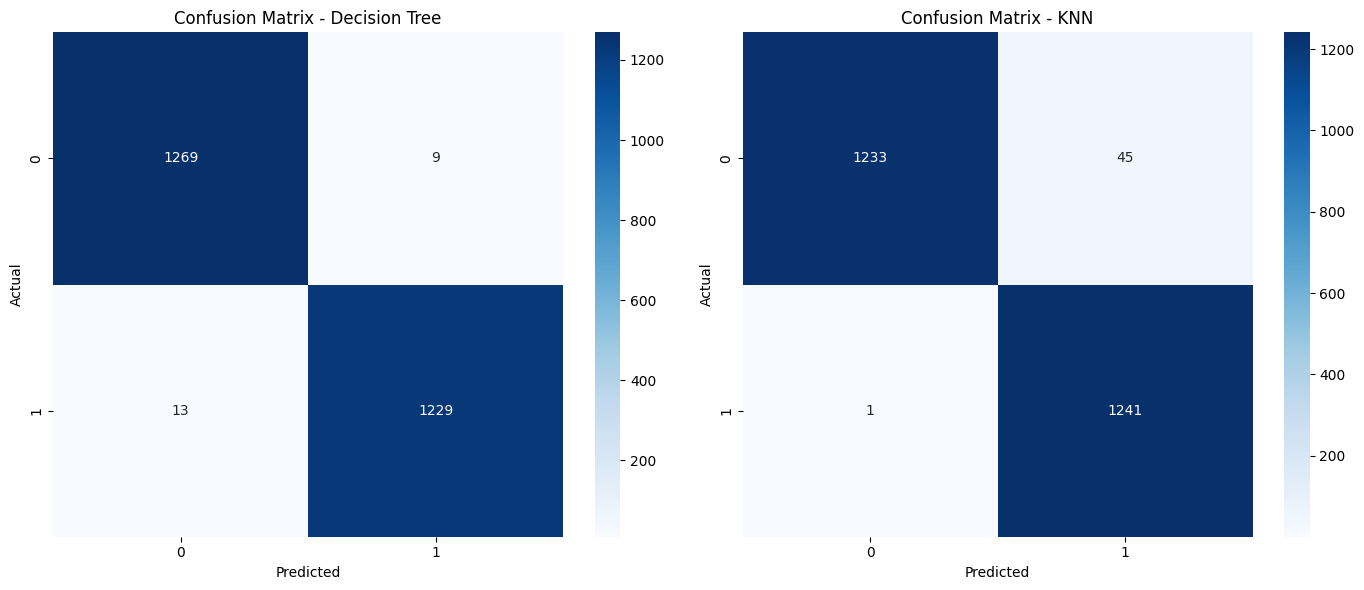

In [56]:
# Perform t-test and Wilcoxon Signed-Rank Test
# Example comparison between Decision Tree and KNN models
axis =1

scores_dt = cross_val_score(dt_clf, X_train, y_train.argmax(axis=1), cv=5)
scores_knn = cross_val_score(knn_clf, X_train, y_train.argmax(axis=1), cv=5)

# t-test
t_stat, p_value_ttest = ttest_ind(scores_dt, scores_knn)
print(f"t-test: t_stat = {t_stat:.4f}, p_value = {p_value_ttest:.4f}")

# Wilcoxon Signed-Rank Test
scores_dt_test = cross_val_score(dt_clf, X_test, y_test.argmax(axis=1), cv=5)
scores_knn_test = cross_val_score(knn_clf, X_test, y_test.argmax(axis=1), cv=5)
wilcoxon_stat, p_value_wilcoxon = wilcoxon(scores_dt_test, scores_knn_test)
print(f"Wilcoxon Signed-Rank Test: wilcoxon_stat = {wilcoxon_stat:.4f}, p_value = {p_value_wilcoxon:.4f}")

# Visualize Confusion Matrix for one of the models
cm_dt = confusion_matrix(y_test.argmax(axis), y_pred_dt)
cm_knn = confusion_matrix(y_test.argmax(axis), y_pred_knn)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()
